# Potato Disease Classification

Dataset credits: https://www.kaggle.com/arjuntejaswi/plant-village

### Import all the Dependencies

In [1]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2024-10-22 20:06:46.457146: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-22 20:06:46.504092: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-22 20:06:46.518515: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-22 20:06:46.604948: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  1


I0000 00:00:1729616808.686782    9021 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729616808.722752    9021 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729616808.722888    9021 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [2]:
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
import tensorflow as tf

from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
import numpy as np

### Import data into tensorflow dataset object

Used splitfolders tool to split dataset into training, validation and test directories.

$ pip install split-folders

$ splitfolders --ratio 0.8 0.1 0.1 -- ./training/PlantVillage/


In [3]:
IMAGE_SIZE = 256
CHANNELS = 3
n_classes = 3
BATCH_SIZE = 32

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        horizontal_flip=True
)
train_generator = train_datagen.flow_from_directory(
        'dataset_1/train',
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=32,
        class_mode="sparse",
)

Found 1506 images belonging to 3 classes.


In [5]:
train_generator.class_indices

{'Potato___Early_blight': 0, 'Potato___Late_blight': 1, 'Potato___healthy': 2}

In [6]:
class_names = list(train_generator.class_indices.keys())
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [7]:
count=0
for image_batch, label_batch in train_generator:
    print(image_batch[0])
    break

[[[0.7049451  0.6814157  0.6814157 ]
  [0.7019608  0.6784314  0.6784314 ]
  [0.70516855 0.68163913 0.68163913]
  ...
  [0.8196079  0.80392164 0.8078432 ]
  [0.8196079  0.80392164 0.8078432 ]
  [0.8196079  0.80392164 0.8078432 ]]

 [[0.7083199  0.6847905  0.6847905 ]
  [0.7019608  0.6784314  0.6784314 ]
  [0.7044935  0.6809641  0.6809641 ]
  ...
  [0.81577533 0.80008906 0.8040106 ]
  [0.81442547 0.7987392  0.80266076]
  [0.81307554 0.7973892  0.8013108 ]]

 [[0.7116948  0.68816537 0.68816537]
  [0.7019608  0.6784314  0.6784314 ]
  [0.70381856 0.68028915 0.68028915]
  ...
  [0.7931875  0.7775012  0.7814228 ]
  [0.78643775 0.7707515  0.77467304]
  [0.779688   0.7640017  0.7679233 ]]

 ...

 [[0.5664858  0.519427   0.52727014]
  [0.5644609  0.51740205 0.5252452 ]
  [0.5624359  0.5153771  0.52322024]
  ...
  [0.56408757 0.5209503  0.5366366 ]
  [0.5529412  0.50980395 0.5254902 ]
  [0.554888   0.51175076 0.52743703]]

 [[0.5588289  0.51177007 0.5196132 ]
  [0.56085384 0.513795   0.52163815]


In [8]:
validation_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        horizontal_flip=True)
validation_generator = validation_datagen.flow_from_directory(
        'dataset_1/val',
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=32,
        class_mode="sparse"
)

Found 215 images belonging to 3 classes.


In [9]:
test_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        horizontal_flip=True)

test_generator = test_datagen.flow_from_directory(
        'dataset_1/test',
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=32,
        class_mode="sparse"
)

Found 431 images belonging to 3 classes.


In [10]:
for image_batch, label_batch in test_generator:
    print(image_batch[0])
    break

[[[0.5032058  0.48751947 0.54513955]
  [0.5085508  0.49286455 0.55093   ]
  [0.51389587 0.49820957 0.55672055]
  ...
  [0.5868448  0.57623285 0.6359833 ]
  [0.5654966  0.5537319  0.6258856 ]
  [0.55263    0.5408653  0.60993886]]

 [[0.46823213 0.45254585 0.50744784]
  [0.46912298 0.4534367  0.5083387 ]
  [0.47001383 0.45432755 0.5092295 ]
  ...
  [0.58283603 0.5717786  0.6342017 ]
  [0.5637149  0.5519502  0.6249947 ]
  [0.55129373 0.539529   0.60771173]]

 [[0.48234084 0.46665457 0.5215565 ]
  [0.47476867 0.4590824  0.5139844 ]
  [0.4671965  0.45151022 0.5064122 ]
  ...
  [0.57882726 0.5673244  0.63242   ]
  [0.5619332  0.5501685  0.6241039 ]
  [0.54995745 0.53819275 0.60548466]]

 ...

 [[0.6691675  0.6613244  0.71622634]
  [0.6997626  0.69191945 0.7468214 ]
  [0.72104496 0.7132018  0.7681038 ]
  ...
  [0.6596152  0.65569365 0.7105956 ]
  [0.6676328  0.66371125 0.7186132 ]
  [0.6756504  0.67172885 0.7266308 ]]

 [[0.6727309  0.6648878  0.71978974]
  [0.7024351  0.69459194 0.74949396]


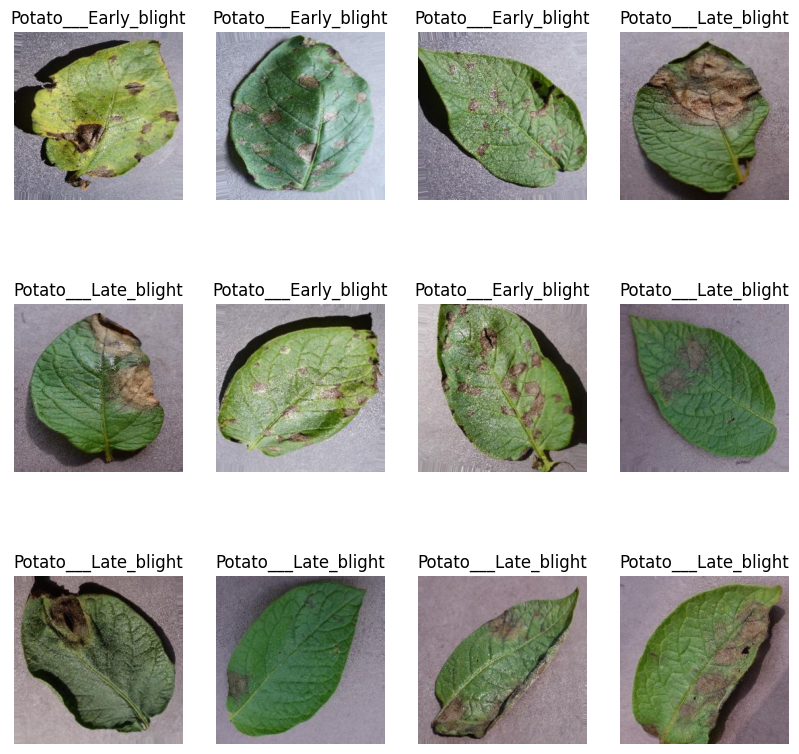

In [11]:
# Get a batch of images and labels from the train generator
image_batch, labels_batch = next(train_generator)

# Display the first 12 images from the batch
plt.figure(figsize=(10, 10))
for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(image_batch[i])
    plt.title(class_names[int(labels_batch[i])])
    plt.axis("off")
plt.show()


## Building the Model

In [ ]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

base_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten()
])

In [ ]:
model = models.Sequential([
    base_model,
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

In [13]:
classifier = layers.Dense(n_classes, activation='softmax')

In [14]:
model = models.Sequential([base_model, classifier])

In [15]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 64)             │       183,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [16]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [17]:
history = model.fit(
    train_generator,
    steps_per_epoch=47,
    batch_size=32,
    validation_data=validation_generator,
    validation_steps=6,
    verbose=1,
    epochs=30,
)

/home/kecheste/Documents/Internships/iCog/training/CNN-training/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1729616882.441096    9916 service.cc:146] XLA service 0x77ef88003b50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729616882.441114    9916 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2024-10-22 20:08:02.486683: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-22 20:08:02.720447: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 2/47 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.4766 - loss: 1.0882

I0000 00:00:1729616887.952569    9916 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


47/47 ━━━━━━━━━━━━━━━━━━━━ 26s 406ms/step - accuracy: 0.4737 - loss: 0.9718 - val_accuracy: 0.6823 - val_loss: 0.8568
Epoch 2/30
 1/47 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6875 - loss: 0.9200

2024-10-22 20:08:26.669411: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-22 20:08:26.669544: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/usr/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6875 - loss: 0.9200 - val_accuracy: 0.4783 - val_loss: 1.0150
Epoch 3/30


2024-10-22 20:08:28.042944: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-10-22 20:08:28.043111: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3103835978566161556


47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 335ms/step - accuracy: 0.5845 - loss: 0.8414 - val_accuracy: 0.7396 - val_loss: 0.6598
Epoch 4/30
 1/47 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6250 - loss: 0.8991

2024-10-22 20:08:43.838681: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3103835978566161556


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6250 - loss: 0.8991 - val_accuracy: 0.8696 - val_loss: 0.4681
Epoch 5/30


2024-10-22 20:08:44.043603: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-10-22 20:08:44.043655: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3103835978566161556


47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 337ms/step - accuracy: 0.7997 - loss: 0.4910 - val_accuracy: 0.8438 - val_loss: 0.4263
Epoch 6/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8750 - loss: 0.3293 - val_accuracy: 0.7826 - val_loss: 0.4615
Epoch 7/30


2024-10-22 20:09:00.101293: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8473024146093596491
2024-10-22 20:09:00.101321: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3103835978566161556


47/47 ━━━━━━━━━━━━━━━━━━━━ 15s 313ms/step - accuracy: 0.8623 - loss: 0.3539 - val_accuracy: 0.8750 - val_loss: 0.3336
Epoch 8/30
 1/47 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8750 - loss: 0.2890

2024-10-22 20:09:14.840828: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8473024146093596491
2024-10-22 20:09:14.840863: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3103835978566161556


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8750 - loss: 0.2890 - val_accuracy: 0.9565 - val_loss: 0.1095
Epoch 9/30


2024-10-22 20:09:15.055584: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-10-22 20:09:15.055661: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8473024146093596491
2024-10-22 20:09:15.055675: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3103835978566161556


47/47 ━━━━━━━━━━━━━━━━━━━━ 15s 323ms/step - accuracy: 0.8822 - loss: 0.2759 - val_accuracy: 0.8542 - val_loss: 0.3682
Epoch 10/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8750 - loss: 0.3929 - val_accuracy: 0.7826 - val_loss: 0.4326
Epoch 11/30


2024-10-22 20:09:30.488950: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8473024146093596491
2024-10-22 20:09:30.488998: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3103835978566161556


47/47 ━━━━━━━━━━━━━━━━━━━━ 15s 329ms/step - accuracy: 0.8867 - loss: 0.2957 - val_accuracy: 0.8750 - val_loss: 0.2901
Epoch 12/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8438 - loss: 0.4029 - val_accuracy: 0.8261 - val_loss: 0.2834
Epoch 13/30


2024-10-22 20:09:46.180201: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8473024146093596491
2024-10-22 20:09:46.180228: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3103835978566161556


47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 337ms/step - accuracy: 0.8613 - loss: 0.3198 - val_accuracy: 0.8438 - val_loss: 0.3706
Epoch 14/30
 1/47 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9375 - loss: 0.2228

2024-10-22 20:10:02.050235: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8473024146093596491
2024-10-22 20:10:02.050269: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3103835978566161556


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9375 - loss: 0.2228 - val_accuracy: 0.8261 - val_loss: 0.4662
Epoch 15/30


2024-10-22 20:10:02.260052: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8473024146093596491
2024-10-22 20:10:02.260086: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3103835978566161556


47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 339ms/step - accuracy: 0.9102 - loss: 0.2214 - val_accuracy: 0.9010 - val_loss: 0.2888
Epoch 16/30
 1/47 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9375 - loss: 0.1404

2024-10-22 20:10:18.224888: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3103835978566161556


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9375 - loss: 0.1404 - val_accuracy: 0.9130 - val_loss: 0.1908
Epoch 17/30


2024-10-22 20:10:18.430794: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-10-22 20:10:18.430897: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8473024146093596491
2024-10-22 20:10:18.430937: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3103835978566161556


47/47 ━━━━━━━━━━━━━━━━━━━━ 15s 321ms/step - accuracy: 0.8968 - loss: 0.2407 - val_accuracy: 0.8906 - val_loss: 0.2131
Epoch 18/30
 1/47 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9688 - loss: 0.1246

2024-10-22 20:10:33.577141: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8473024146093596491
2024-10-22 20:10:33.577173: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3103835978566161556


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9688 - loss: 0.1246 - val_accuracy: 0.7826 - val_loss: 0.3835
Epoch 19/30


2024-10-22 20:10:33.791568: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8473024146093596491
2024-10-22 20:10:33.791660: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3103835978566161556


47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 337ms/step - accuracy: 0.9523 - loss: 0.1416 - val_accuracy: 0.9010 - val_loss: 0.1926
Epoch 20/30
 1/47 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8750 - loss: 0.3574

2024-10-22 20:10:49.703496: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8473024146093596491
2024-10-22 20:10:49.703529: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3103835978566161556


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8750 - loss: 0.3574 - val_accuracy: 0.8261 - val_loss: 0.2761
Epoch 21/30


2024-10-22 20:10:49.907825: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8473024146093596491
2024-10-22 20:10:49.907854: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3103835978566161556


47/47 ━━━━━━━━━━━━━━━━━━━━ 15s 327ms/step - accuracy: 0.9103 - loss: 0.2097 - val_accuracy: 0.9167 - val_loss: 0.1837
Epoch 22/30
 1/47 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9688 - loss: 0.0925

2024-10-22 20:11:05.307833: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8473024146093596491
2024-10-22 20:11:05.307861: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3103835978566161556


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9688 - loss: 0.0925 - val_accuracy: 0.8261 - val_loss: 0.3524
Epoch 23/30


2024-10-22 20:11:05.519544: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8473024146093596491
2024-10-22 20:11:05.519573: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3103835978566161556


47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 332ms/step - accuracy: 0.9493 - loss: 0.1311 - val_accuracy: 0.9323 - val_loss: 0.2002
Epoch 24/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.1236 - val_accuracy: 0.9565 - val_loss: 0.1404
Epoch 25/30


2024-10-22 20:11:21.365893: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8473024146093596491
2024-10-22 20:11:21.365948: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3103835978566161556


47/47 ━━━━━━━━━━━━━━━━━━━━ 15s 320ms/step - accuracy: 0.9488 - loss: 0.1203 - val_accuracy: 0.8385 - val_loss: 0.4788
Epoch 26/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8438 - loss: 0.6062 - val_accuracy: 0.8261 - val_loss: 0.4074
Epoch 27/30


2024-10-22 20:11:36.664916: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8473024146093596491
2024-10-22 20:11:36.664943: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3103835978566161556


47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 329ms/step - accuracy: 0.9202 - loss: 0.1993 - val_accuracy: 0.9479 - val_loss: 0.1566
Epoch 28/30
 1/47 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9375 - loss: 0.1143

2024-10-22 20:11:52.181989: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3103835978566161556


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9375 - loss: 0.1143 - val_accuracy: 0.7391 - val_loss: 0.6119
Epoch 29/30


2024-10-22 20:11:52.411714: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8473024146093596491
2024-10-22 20:11:52.411755: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3103835978566161556


47/47 ━━━━━━━━━━━━━━━━━━━━ 15s 316ms/step - accuracy: 0.9629 - loss: 0.1104 - val_accuracy: 0.9479 - val_loss: 0.1358
Epoch 30/30
 1/47 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 1.0000 - loss: 0.0223

2024-10-22 20:12:07.340746: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8473024146093596491
2024-10-22 20:12:07.340792: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3103835978566161556
2024-10-22 20:12:07.539811: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3103835978566161556


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0223 - val_accuracy: 0.9565 - val_loss: 0.0742


In [18]:
dummy_input = np.zeros((1, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
model.predict(dummy_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step


array([[0.313717  , 0.68521273, 0.00107034]], dtype=float32)

In [20]:
feature_extractor = models.Model(inputs=model.input, outputs=base_model.output)

AttributeError: The layer sequential_1 has never been called and thus has no defined input.

In [54]:
train_features = feature_extractor.predict(train_generator)

NameError: name 'feature_extractor' is not defined

In [55]:
isolation_forest = IsolationForest(contamination=0.1)
one_class_svm = OneClassSVM(gamma='auto')
local_outlier_factor = LocalOutlierFactor(n_neighbors=20)

In [ ]:
isolation_forest.fit(train_features)
one_class_svm.fit(train_features)
lof_predictions = local_outlier_factor.fit_predict(train_features)

In [ ]:
def is_outlier(features):
    if isolation_forest.predict([features])[0] == -1: return True
    if one_class_svm.predict([features])[0] == -1: return True
    if local_outlier_factor._predict([features])[0] == -1: return True
    return False

In [51]:
scores = model.evaluate(test_generator)

17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 306ms/step - accuracy: 0.9788 - loss: 0.0789


In [52]:
scores

[0.08530914783477783, 0.9766082167625427]

Scores is just a list containing loss and accuracy value

### Plotting the Accuracy and Loss Curves

In [53]:
history

You can read documentation on history object here: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History

In [54]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 47}

In [55]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

**loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch**

In [56]:
type(history.history['loss'])

list

In [57]:
len(history.history['loss'])

30

In [58]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.1599096059799194,
 1.040514349937439,
 0.7660993933677673,
 0.5898095369338989,
 0.5003569722175598]

In [60]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [61]:
val_acc

[0.484375,
 0.5049505233764648,
 0.7708333134651184,
 0.7227723002433777,
 0.8229166865348816,
 0.8514851331710815,
 0.9114583134651184,
 0.9207921028137207,
 0.9114583134651184,
 0.9504950642585754,
 0.9635416865348816,
 0.9504950642585754,
 0.953125,
 0.9603960514068604,
 0.9635416865348816,
 0.9801980257034302,
 0.9427083134651184,
 0.9900990128517151,
 0.9791666865348816,
 0.9207921028137207,
 0.9791666865348816,
 0.8613861203193665,
 0.9479166865348816,
 0.9900990128517151,
 0.9895833134651184,
 0.8712871074676514,
 0.984375,
 1.0,
 0.984375,
 0.9900990128517151]

In [62]:
acc

[0.4166666567325592,
 0.5372023582458496,
 0.6863143444061279,
 0.7648809552192688,
 0.8018617033958435,
 0.8354037404060364,
 0.8638211488723755,
 0.9345238208770752,
 0.934959352016449,
 0.9404761791229248,
 0.9634146094322205,
 0.9598214030265808,
 0.9823848009109497,
 0.956845223903656,
 0.9381648898124695,
 0.9254658222198486,
 0.9607046246528625,
 0.9836309552192688,
 0.9857723712921143,
 0.988095223903656,
 0.967420220375061,
 0.9720497131347656,
 0.9561170339584351,
 0.967391312122345,
 0.9873670339584351,
 0.9767080545425415,
 0.9735772609710693,
 0.9672619104385376,
 0.9720744490623474,
 0.989130437374115]

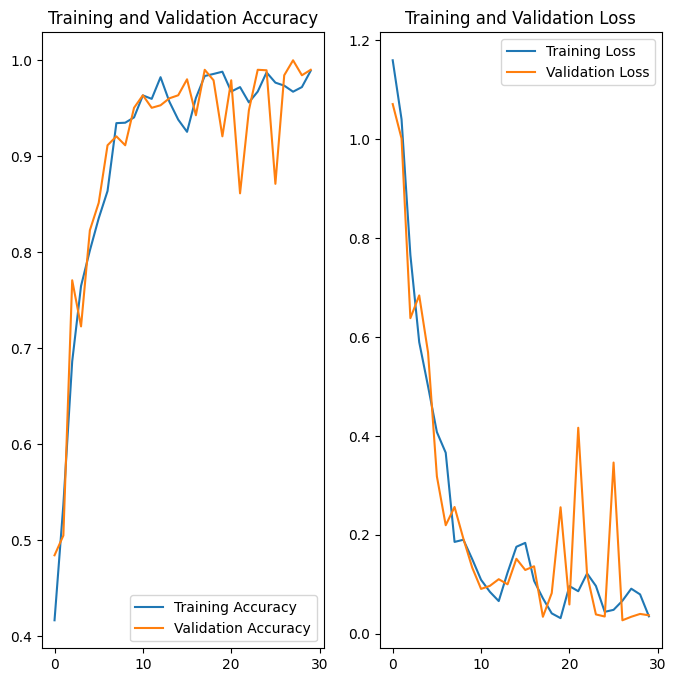

In [63]:
EPOCHS = 30

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Run prediction on a sample image

First image to predict
Actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
Predicted label: Potato___Early_blight


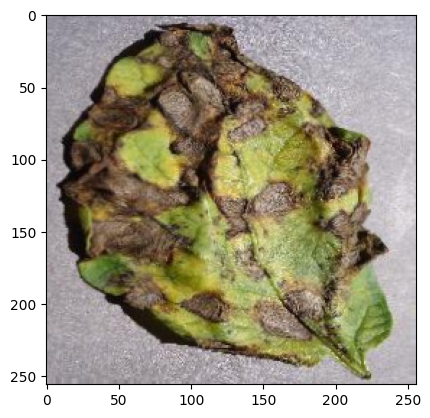

In [64]:
for image_batch, label_batch in test_generator:
    first_image = image_batch[0]
    first_label = int(label_batch[0])  
    
    print("First image to predict")
    plt.imshow(first_image)
    print("Actual label:", class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print("Predicted label:", class_names[np.argmax(batch_prediction[0])])
    
    break

### Write a function for inference

In [65]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    
    features = feature_extractor.predict(img_array)
    
    if is_outlier(features[0]):
        return "Outlier detected (not a valid potato leaf)", 0.0

    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    confidence = np.max(predictions[0])
    return predicted_class, confidence

**Now run inference on few sample images**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


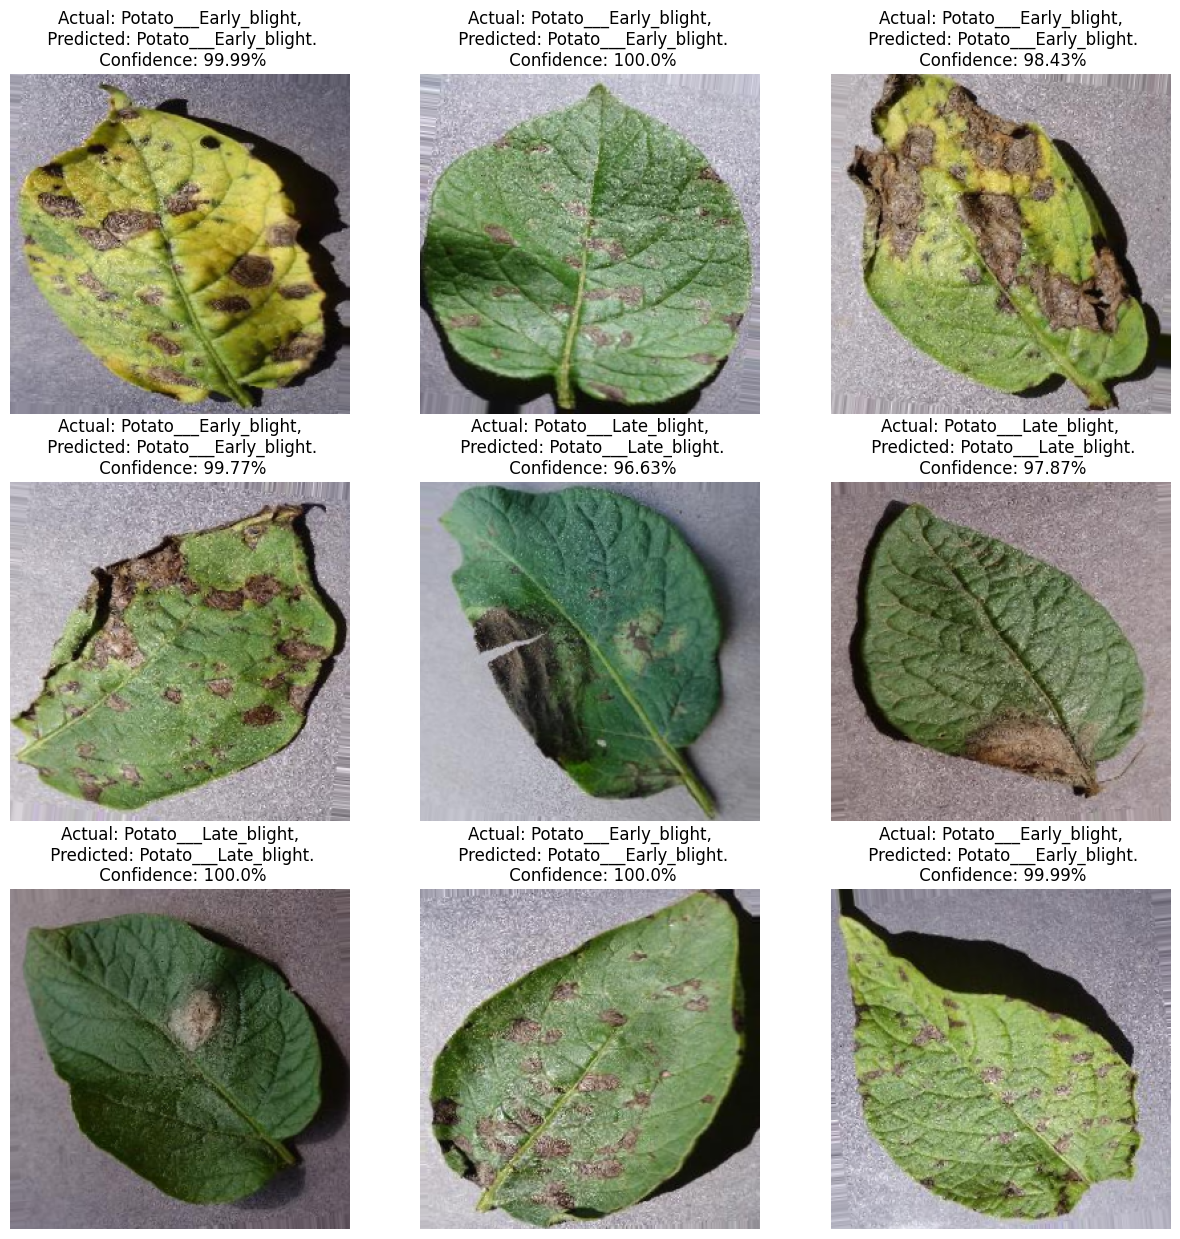

In [66]:
plt.figure(figsize=(15, 15))
for images, labels in test_generator:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        
        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[int(labels[i])] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
    break

### Saving the Model

Save model in h5 format so that there is just one file and we can upload that to GCP conveniently

In [67]:
model.save("../saved-models/another-model.keras")